In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datetime
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
def stock_data(stockList, factor, startDate, endDate):
    data = w.wsd(stockList, factor, startDate, endDate, "")
    df = pd.DataFrame(data.Data, columns = data.Times, index = stockList).T
    return df

In [3]:
def updateMoney(t,t_lasttime,weights,money,stockClose,merged_data):
    dailyReturnOfBond = merged_data.loc[t_lasttime: t]['bond10y'].mean()/365
    bondIncome = (t-t_lasttime).days * dailyReturnOfBond * (1-weights) * money
    stockIncome = (stockClose[t]-stockClose[t_lasttime])/stockClose[t_lasttime] * weights * money
    money += (stockIncome + bondIncome)
    return money

In [4]:
stockList = ["000300.SH","000905.SH","399006.SZ","881001.WI"]
startDate = "20090101"
endDate = "20210101"
N = 1 # N-month return of index

stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

In [5]:
# pd.set_option('display.max_rows', None)
# returnRatio

## 四种指数（沪深300、中证500、创业板、万得全A）股债比

<AxesSubplot:>

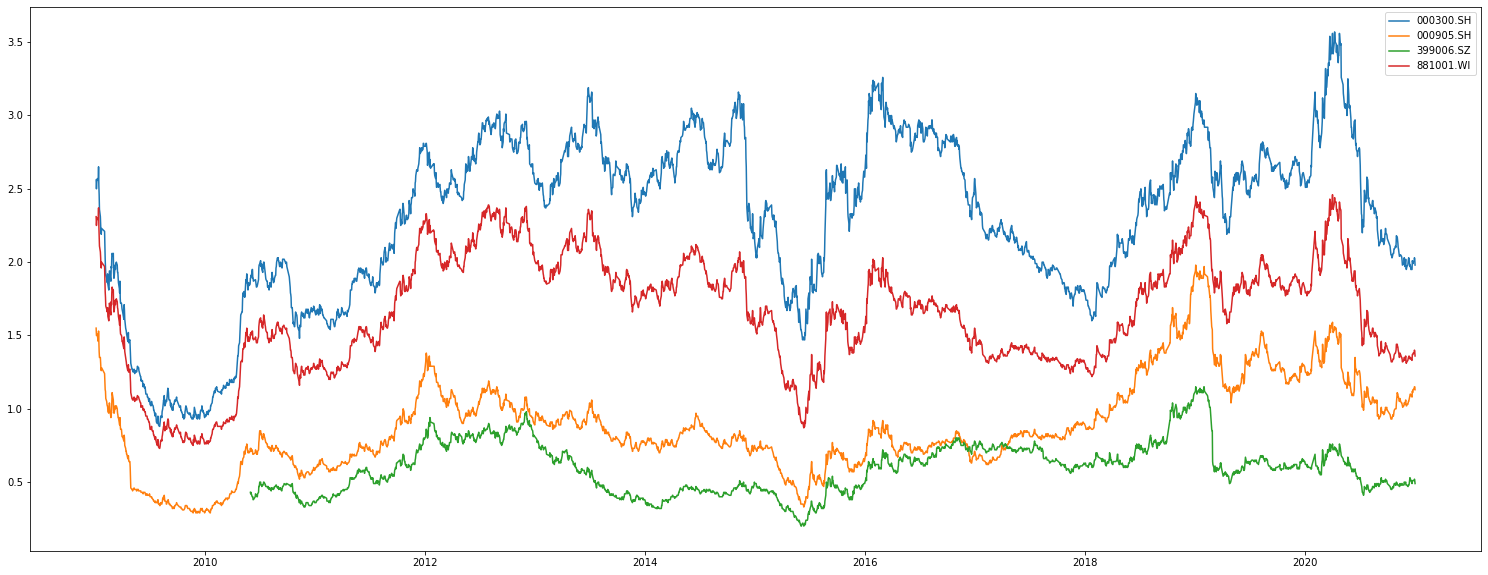

In [6]:
returnRatio.plot(figsize=(26,10))

In [7]:
def return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data):
    m = returnRatio[returnRatio.columns[stock_num]]
    stockClose = stockClosedf[stockClosedf.columns[stock_num]]

    t = t_lasttime = testStartDate
    weights_new = weights_lasttime = weight_stock(m[:t],m[t])
    money = 1

    time_all = []
    money_all = []
    index_all = []
    position_all = []
    time_all.append(t)
    money_all.append(money)
    index_all.append(stockClose[t])
    position_all.append(weights_new)

    testStart_indexNum = m.index.tolist().index(testStartDate)
    
    count = 0
    for i in range(testStart_indexNum+1,len(m)):   
        if i%21 == 0:
            weights_new = weight_stock(m[:(i+1)],m[i])
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money,stockClose,merged_data)
            weights_lasttime = weights_new
            t_lasttime = t

            time_all.append(t)
            money_all.append(money)
            index_all.append(stockClose[t])
            position_all.append(weights_new)
            
            
            count+=1
#             if count == 10:
#                 break

    startYear = str(testStartDate).split("-")[0]
    if startYear == '2014':
        denominator = 7
    elif startYear == '2015':
        denominator = 6
    elif startYear == '2016':
        denominator = 5
    elif startYear == '2017':
        denominator = 4
    print(m.name)
    print("训练开始日期("+str(stockClose.index[0])+")："+str(stockClose[0]) + "   测试开始日期("+str(testStartDate)+")："+str(stockClose[testStart_indexNum]) +"    结束日期("+str(stockClose.index[-1])+")："+str(stockClose[-1]))
    print("指数总收益率： " + str(stockClose[-1]/stockClose[testStart_indexNum] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[testStart_indexNum])**(1/denominator) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/denominator) - 1))
    print()
    return[time_all,money_all,position_all]

In [8]:
def weight_stock(m, ratio):
    N_sect = 10
    weights = [i for i in np.arange(0,1,1/N_sect)]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.432953272316587   策略年化收益率： 0.13543418830844467



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.6,0.000000,2321.9780,0.000000
2014-01-14,0.972407,0.7,-0.027981,2212.8460,-0.048140
2014-02-19,1.003179,0.7,0.031156,2308.6560,0.042386
2014-03-20,0.936817,0.8,-0.068442,2086.9670,-0.100954
2014-04-21,0.973563,0.8,0.038475,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.363054,0.5,0.047602,4771.3108,0.076573
2020-09-01,2.383395,0.4,0.008571,4842.1223,0.014732
2020-09-30,2.336777,0.4,-0.019753,4587.3953,-0.054041
2020-11-06,2.402097,0.4,0.027569,4885.7178,0.063004


# 股债比和仓位3等分 [0, 0.33, 0.66]

In [9]:
def weight_stock(m, ratio):
    N_sect = 3
    weights = [i for i in np.arange(0,1,1/N_sect)]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.2182304840747844   策略年化收益率： 0.12054557310081271



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.67,0.000000,2321.9780,0.000000
2014-01-14,0.96901,0.67,-0.031480,2212.8460,-0.048140
2014-02-19,0.998547,0.67,0.030026,2308.6560,0.042386
2014-03-20,0.935474,0.67,-0.065248,2086.9670,-0.100954
2014-04-21,0.966801,0.67,0.032939,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.16343,0.33,0.027562,4771.3108,0.076573
2020-09-01,2.177468,0.33,0.006468,4842.1223,0.014732
2020-09-30,2.143273,0.33,-0.015828,4587.3953,-0.054041
2020-11-06,2.193913,0.33,0.023352,4885.7178,0.063004


# 股债比和仓位5等分

In [10]:
def weight_stock(m, ratio):
    N_sect = 5
    weights = [i for i in np.arange(0,1,1/N_sect)]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.4068768971624852   策略年化收益率： 0.133687638449294



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.6,0.000000,2321.9780,0.000000
2014-01-14,0.972407,0.6,-0.027981,2212.8460,-0.048140
2014-02-19,0.999403,0.6,0.027384,2308.6560,0.042386
2014-03-20,0.943242,0.8,-0.057835,2086.9670,-0.100954
2014-04-21,0.98024,0.8,0.038475,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.340619,0.4,0.047602,4771.3108,0.076573
2020-09-01,2.357849,0.4,0.007334,4842.1223,0.014732
2020-09-30,2.311732,0.4,-0.019753,4587.3953,-0.054041
2020-11-06,2.376351,0.4,0.027569,4885.7178,0.063004


# 股债比和仓位7等分

In [11]:
def weight_stock(m, ratio):
    N_sect = 7
    weights = [i for i in np.arange(0,1,1/N_sect)]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.416555099395215   策略年化收益率： 0.13433775163682316



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.57,0.000000,2321.9780,0.000000
2014-01-14,0.973862,0.71,-0.026486,2212.8460,-0.048140
2014-02-19,1.005059,0.57,0.031532,2308.6560,0.042386
2014-03-20,0.951583,0.71,-0.054675,2086.9670,-0.100954
2014-04-21,0.985129,0.71,0.034646,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.347139,0.43,0.045395,4771.3108,0.076573
2020-09-01,2.365295,0.43,0.007706,4842.1223,0.014732
2020-09-30,2.315124,0.43,-0.021440,4587.3953,-0.054041
2020-11-06,2.38413,0.43,0.029371,4885.7178,0.063004


# 股债比和仓位15等分

In [12]:
def weight_stock(m, ratio):
    N_sect = 15
    weights = [i for i in np.arange(0,1,1/N_sect)]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.3933398535095152   策略年化收益率： 0.132774546430938



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.67,0.000000,2321.9780,0.000000
2014-01-14,0.96901,0.67,-0.031480,2212.8460,-0.048140
2014-02-19,0.998547,0.67,0.030026,2308.6560,0.042386
2014-03-20,0.935474,0.8,-0.065248,2086.9670,-0.100954
2014-04-21,0.972167,0.8,0.038475,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.323115,0.53,0.047602,4771.3108,0.076573
2020-09-01,2.343981,0.47,0.008942,4842.1223,0.014732
2020-09-30,2.289097,0.47,-0.023693,4587.3953,-0.054041
2020-11-06,2.362986,0.4,0.031769,4885.7178,0.063004


# 股债比和仓位20等分 

In [13]:
def weight_stock(m, ratio):
    N_sect = 20
    weights = [i for i in np.arange(0,1,1/N_sect)]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.3947920848758972   策略年化收益率： 0.13287271308121262



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.65,0.000000,2321.9780,0.000000
2014-01-14,0.969981,0.7,-0.030479,2212.8460,-0.048140
2014-02-19,1.000677,0.7,0.031156,2308.6560,0.042386
2014-03-20,0.93448,0.8,-0.068442,2086.9670,-0.100954
2014-04-21,0.971135,0.8,0.038475,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.324114,0.55,0.047602,4771.3108,0.076573
2020-09-01,2.345569,0.45,0.009189,4842.1223,0.014732
2020-09-30,2.293232,0.45,-0.022566,4587.3953,-0.054041
2020-11-06,2.36442,0.4,0.030571,4885.7178,0.063004


# 经过测试（3-15等分都已测试），10等分(股债比&仓位比均等分）下收益率最佳

# 3分 [0,0.5,1]

In [14]:
def weight_stock(m, ratio):
    N_sect = 3
    weights =[i for i in np.arange(0,1.0000001,1/(N_sect-1))]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.8196656523221444   策略年化收益率： 0.15961532147475177



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,1.0,0.000000,2321.9780,0.000000
2014-01-14,0.953,1.0,-0.048140,2212.8460,-0.048140
2014-02-19,0.994263,1.0,0.042386,2308.6560,0.042386
2014-03-20,0.898788,1.0,-0.100954,2086.9670,-0.100954
2014-04-21,0.941976,1.0,0.046932,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.730886,0.5,0.040227,4771.3108,0.076573
2020-09-01,2.754393,0.5,0.008571,4842.1223,0.014732
2020-09-30,2.685348,0.5,-0.025387,4587.3953,-0.054041
2020-11-06,2.777006,0.5,0.033563,4885.7178,0.063004


#  4分[0.0, 0.333, 0.666, 1.0]

In [15]:
def weight_stock(m, ratio):
    N_sect = 4
    weights =[i for i in np.arange(0,1.0000001,1/(N_sect-1))]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.3950054830993253   策略年化收益率： 0.13288713388529838



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.67,0.000000,2321.9780,0.000000
2014-01-14,0.96901,0.67,-0.031480,2212.8460,-0.048140
2014-02-19,0.998547,0.67,0.030026,2308.6560,0.042386
2014-03-20,0.935474,1.0,-0.065248,2086.9670,-0.100954
2014-04-21,0.980424,1.0,0.046932,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.326042,0.67,0.052733,4771.3108,0.076573
2020-09-01,2.350994,0.33,0.010670,4842.1223,0.014732
2020-09-30,2.314075,0.33,-0.015828,4587.3953,-0.054041
2020-11-06,2.36875,0.33,0.023352,4885.7178,0.063004


# 5分

In [16]:
def weight_stock(m, ratio):
    N_sect = 5
    weights =[i for i in np.arange(0,1.0000001,1/(N_sect-1))]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.7692810350933303   策略年化收益率： 0.15663223079298705



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.75,0.000000,2321.9780,0.000000
2014-01-14,0.965129,0.75,-0.035493,2212.8460,-0.048140
2014-02-19,0.997546,0.75,0.033036,2308.6560,0.042386
2014-03-20,0.926589,1.0,-0.073788,2086.9670,-0.100954
2014-04-21,0.971113,1.0,0.046932,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.682088,0.5,0.058565,4771.3108,0.076573
2020-09-01,2.705175,0.5,0.008571,4842.1223,0.014732
2020-09-30,2.637364,0.5,-0.025387,4587.3953,-0.054041
2020-11-06,2.727384,0.5,0.033563,4885.7178,0.063004


# 7分

In [17]:
def weight_stock(m, ratio):
    N_sect = 7
    weights =[i for i in np.arange(0,1.0000001,1/(N_sect-1))]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.6490354616151324   策略年化收益率： 0.1493203866687003



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.67,0.000000,2321.9780,0.000000
2014-01-14,0.96901,0.83,-0.031480,2212.8460,-0.048140
2014-02-19,1.004568,0.67,0.036038,2308.6560,0.042386
2014-03-20,0.941115,0.83,-0.065248,2086.9670,-0.100954
2014-04-21,0.979276,0.83,0.039748,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.565628,0.5,0.052733,4771.3108,0.076573
2020-09-01,2.587713,0.5,0.008571,4842.1223,0.014732
2020-09-30,2.522846,0.5,-0.025387,4587.3953,-0.054041
2020-11-06,2.608958,0.5,0.033563,4885.7178,0.063004


# 10分

In [18]:
def weight_stock(m, ratio):
    N_sect = 10
    weights =[i for i in np.arange(0,1.0000001,1/(N_sect-1))]
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
#     print(weights)
    return np.around(weights[index],decimals =2)

stock_num = 0
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,position_all] = return_strategy_benchmark(stock_num,testStartDate,returnRatio,stockClosedf,merged_data)

stockClose = stockClosedf[stockClosedf.columns[stock_num]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info[stockClose.name].to_frame()/info[stockClose.name].to_frame().shift()).fillna(value = 1))
info

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2330.026    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2365795488977378   指数年化收益率： 0.12186505748668153
策略总收益率： 1.5876848601234803   策略年化收益率： 0.14547955123782397



,资金,仓位,策略收益率,000300.SH,指数收益率
2014-01-02,1,0.67,0.000000,2321.9780,0.000000
2014-01-14,0.96901,0.78,-0.031480,2212.8460,-0.048140
2014-02-19,1.002687,0.78,0.034163,2308.6560,0.042386
2014-03-20,0.928369,0.89,-0.077009,2086.9670,-0.100954
2014-04-21,0.968471,0.89,0.042290,2187.2480,0.046932
...,...,...,...,...,...
2020-08-03,2.508602,0.56,0.052733,4771.3108,0.076573
2020-09-01,2.532073,0.44,0.009312,4842.1223,0.014732
2020-09-30,2.476969,0.44,-0.022003,4587.3953,-0.054041
2020-11-06,2.55233,0.44,0.029971,4885.7178,0.063004


# 有满仓选项后年化收益率提高两个点左右